In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse, mae
import numpy as np

import utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1, should_scale=False, should_log=True
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False, should_scale=False, should_log=True
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12, should_scale=False, should_log=True
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=False, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

# Reconvert to DataFrame since statsmodels does not support TimeSeries objects
train = train_ts_scaled.pd_dataframe()
validation = val_ts_scaled.pd_dataframe()
history = pd.concat([train, validation])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/Xavier/cdpq-ia/utils.py:233: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


# AR Model

In [11]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Compute the optimal lag order on the training set
sel = ar_select_order(train, 12, old_names=False, glob=False, ic="aic")


# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

     # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month using the optimal lag order
    model = AutoReg(hist_t, lags=sel.ar_lags, old_names=False)
    model_fit = model.fit(cov_type="HC0")

    # Forecast for t + 1
    model_fit = model_fit.append(validation[t:t])
    y_pred = model_fit.get_prediction(start=-1, end=t + pd.DateOffset(years=3))
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_dataframe(y_pred.summary_frame(), value_cols=["mean"]), pipeline, ts_scaled)
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})

    # print(y_pred.summary_frame())



    # Append the forecast to the list of forecasts
    y_pred_unscaled["horizon"] = range(1, len(y_pred_unscaled) + 1)
    y_pred_unscaled["date"] = t - pd.offsets.MonthEnd()
    forecasts = pd.concat([forecasts, y_pred_unscaled])

In [12]:
# Selected lags
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [13]:
for h in forecasts["horizon"].unique():
    fore = forecasts[forecasts["horizon"] == h]
    fore_ts = TimeSeries.from_dataframe(fore, value_cols=["mean"])
    mape_error = mape(val_ts, fore_ts)
    rmse_error = rmse(val_ts, fore_ts)
    r2_error = r2_score(val_ts, fore_ts)
    mae_error = mae(val_ts, fore_ts)
    print(f"Horizon {h}: MAPE={mape_error}, RMSE={rmse_error}, R2={r2_error}, MAE={mae_error}")

Horizon 1: MAPE=7.63173439334985, RMSE=0.19056490422331765, R2=0.9533704117029758, MAE=0.1471320081700582
Horizon 2: MAPE=11.180699821873665, RMSE=0.27985206277957775, R2=0.9005069272993382, MAE=0.2095925890087272
Horizon 3: MAPE=16.886889661580216, RMSE=0.40381004753449645, R2=0.7945649516976228, MAE=0.3040158475418257
Horizon 4: MAPE=21.38637593125009, RMSE=0.4959311321891893, R2=0.6930990148194992, MAE=0.37952903105165836
Horizon 5: MAPE=25.715994210758346, RMSE=0.5744749033905959, R2=0.5917857494921548, MAE=0.45520382507570856
Horizon 6: MAPE=29.668409654617523, RMSE=0.6535790850927261, R2=0.47627917622391003, MAE=0.5283995785911672
Horizon 7: MAPE=33.21571673431609, RMSE=0.7389807414911921, R2=0.33483383068135353, MAE=0.5980166021381894
Horizon 8: MAPE=37.494898229118405, RMSE=0.8238289190580035, R2=0.17647319764957914, MAE=0.6786072387981337
Horizon 9: MAPE=41.138956436833645, RMSE=0.9006961011146097, R2=0.020352328189708446, MAE=0.7500859971226388
Horizon 10: MAPE=44.88294697182

In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:      US_TB_YIELD_10YRS   No. Observations:                  523
Model:                    AutoReg(12)   Log Likelihood                -642.033
Method:               Conditional MLE   S.D. of innovations              0.850
Date:                Tue, 07 Jan 2025   AIC                           1312.067
Time:                        14:41:41   BIC                           1371.376
Sample:                    02-28-1981   HQIC                          1335.318
                         - 08-31-2023                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0092      0.038     -0.245      0.807      -0.083       0.065
US_TB_YIELD_10YRS.L1      0.3559      0.062      5.734      0.000       0.234       0.477
US_TB_YIELD_10YRS.L2     -0.1834      0.059     -3.088      0.002      -0.300      -0.067
US_TB_YIELD_10YRS.L3      0.1019      0.056      1.831      0.067      -0.007       0.211
US_TB_YIELD_10YRS.L4     -0.0489      0.067     -0.727      0.467      -0.181       0.083
US_TB_YIELD_10YRS.L5      0.1164      0.072      1.613      0.107      -0.025       0.258
US_TB_YIELD_10YRS.L6     -0.0706      0.060     -1.177      0.239      -0.188       0.047
US_TB_YIELD_10YRS.L7     -0.0298      0.061     -0.489      0.625      -0.150       0.090
US_TB_YIELD_10YRS.L8      0.0851      0.062      1.371      0.170      -0.037       0.207
US_TB_YIELD_10YRS.L9     -0.0579      0.067     -0.865      0.387      -0.189       0.073
US_TB_YIELD_10YRS.L10     0.0218      0.064      0.343      0.732      -0.103       0.146
US_TB_YIELD_10YRS.L11     0.0896      0.073      1.235      0.217      -0.053       0.232
US_TB_YIELD_10YRS.L12    -0.1092      0.059     -1.859      0.063      -0.224       0.006
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2127           -0.3467j            1.2613           -0.4557
AR.2            -1.2127           +0.3467j            1.2613            0.4557
AR.3            -0.7628           -0.8201j            1.1200           -0.3692
AR.4            -0.7628           +0.8201j            1.1200            0.3692
AR.5            -0.1630           -1.1624j            1.1738           -0.2722
AR.6            -0.1630           +1.1624j            1.1738            0.2722
AR.7             0.3781           -1.1135j            1.1760           -0.1979
AR.8             0.3781           +1.1135j            1.1760            0.1979
AR.9             0.9332           -0.7967j            1.2270           -0.1125
AR.10            0.9332           +0.7967j            1.2270            0.1125
AR.11            1.2373           -0.2627j            1.2648           -0.0333
AR.12            1.2373           +0.2627j            1.2648            0.0333
------------------------------------------------------------------------------

Parameters and standard errors were estimated using a different dataset and were then applied to this dataset.
"""

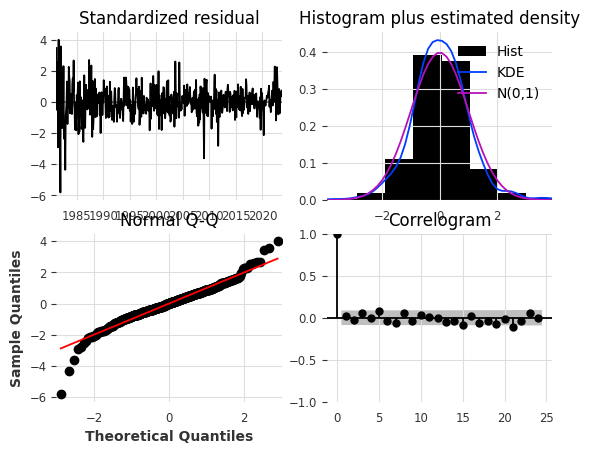

In [5]:
fig = model_fit.plot_diagnostics(lags=24)